In [57]:
%cd /Users/masha/Documents/visual-reasoning

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np

import marimo as mo

# For dinov3
import timm

/Users/masha/Documents/visual-reasoning


Matplotlib is building the font cache; this may take a moment.


In [14]:
train_raw = np.load('./data/train_pairs.npy', allow_pickle=True)
test_raw = np.load('./data/test_balanced.npy', allow_pickle=True)

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def prepare_data(raw_list, is_train=False):
    # Stack all images into one tensor (N, 1, 64, 64)
    x0 = torch.tensor(np.stack([d['x0'] for d in raw_list])).float()
    x1 = torch.tensor(np.stack([d['x1'] for d in raw_list])).float()
    
    # DINOv3 requires 3-channel input even for grayscale data
    x0 = x0.repeat(1, 3, 1, 1)
    x1 = x1.repeat(1, 3, 1, 1)
    
    # Normalize with respect to ImageNet for DINOv3
    x0 = (x0 + 1) * 0.5 
    x1 = (x1 + 1) * 0.5
    # print(x0, x1)
    
    # Apply ImageNet Normalization
    normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    x0 = normalize(x0)
    x1 = normalize(x1)
    
    if is_train:
        y = torch.ones(len(raw_list))
    else:
        y = torch.tensor([1.0 if d.get('label') == 'same' else 0.0 for d in raw_list])
        
    return x0, x1, y

train_x0, train_x1, train_y = prepare_data(train_raw, is_train=True)
test_x0, test_x1, test_y = prepare_data(test_raw, is_train=False)

train_loader = DataLoader(TensorDataset(train_x0, train_x1, train_y), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(test_x0, test_x1, test_y), batch_size=32)

batch = next(iter(train_loader))
print(f"Batch Shape: {batch[0].shape}")
print(f"Label Shape: {batch[2].shape}")

Batch Shape: torch.Size([32, 3, 64, 64])
Label Shape: torch.Size([32])


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))
    def forward(self, x): return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [59]:
class FlowReasoningModel(nn.Module):
    def __init__(self, backbone, backbone_dim=384, flow_dim=64):
        super().__init__()
        
        # 1. Backbone (Frozen)
        self.backbone = backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        self.backbone_dim = backbone_dim

        # 2. Time Embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, flow_dim * 4),
            nn.GELU(),
            nn.Linear(flow_dim * 4, flow_dim * 4)
        )

        # 3. Encoder (Downsampling)
        # x_t (3) -> 64
        self.inc = DoubleConv(3, flow_dim)            
        # 64 -> 128
        self.down1 = Down(flow_dim, flow_dim * 2)     
        # 128 -> 256 (Bottleneck)
        self.down2 = Down(flow_dim * 2, flow_dim * 4) 
        
        # 4. Condition Projector (DINO -> Bottleneck)
        # Maps 384 -> 256
        self.cond_proj = nn.Linear(backbone_dim, flow_dim * 4)

        # 5. Decoder (Upsampling) -- FIXED CHANNELS HERE --
        
        # UP1: Receives Bottleneck (256) + Skip from down1 (128) = 384 channels total
        # 384 is 'flow_dim * 6' (since 64*6 = 384)
        self.up1 = Up(flow_dim * 6, flow_dim * 2) 
        
        # UP2: Receives Output of UP1 (128) + Skip from inc (64) = 192 channels total
        # 192 is 'flow_dim * 3' (since 64*3 = 192)
        self.up2 = Up(flow_dim * 3, flow_dim)
        
        # Output Velocity (3 channels)
        self.outc = nn.Conv2d(flow_dim, 3, kernel_size=1)

    def forward(self, x_t, t, x0_clean):
        # 1. DINO Features
        with torch.no_grad():
            feats = self.backbone.forward_features(x0_clean)
            cls_token = feats[:, 0, :] 

        # 2. Embeddings
        t_emb = self.time_mlp(t)             
        cond = self.cond_proj(cls_token)     
        
        # 3. Encoder
        x1 = self.inc(x_t)        # 64 ch
        x2 = self.down1(x1)       # 128 ch
        x3 = self.down2(x2)       # 256 ch
        
        # Inject Reasoning
        global_cond = (t_emb + cond).unsqueeze(-1).unsqueeze(-1)
        x3 = x3 + global_cond
        
        # 4. Decoder
        x = self.up1(x3, x2)      # Concats 256+128 -> 384. Layer expects 384.
        x = self.up2(x, x1)       # Concats 128+64 -> 192. Layer expects 192.
        
        return self.outc(x)

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dinov3 = timm.create_model(
    "vit_small_patch16_dinov3",
    pretrained=True
)

dinov3.to(device)
dinov3.eval()

model = FlowReasoningModel(
    backbone=dinov3,
    backbone_dim=384
).to(device)

print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Trainable parameters: 2049411


Starting Flow Training...
Epoch [5/20] Loss: 1.146297


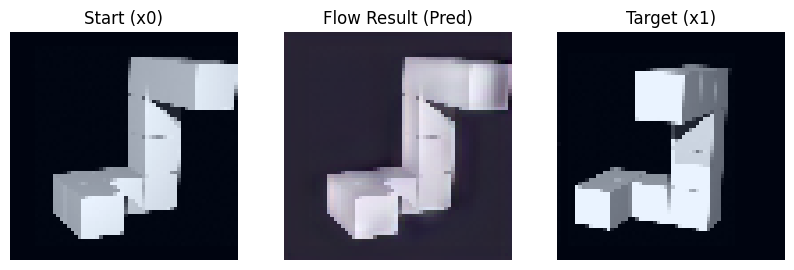

Epoch [10/20] Loss: 0.980941


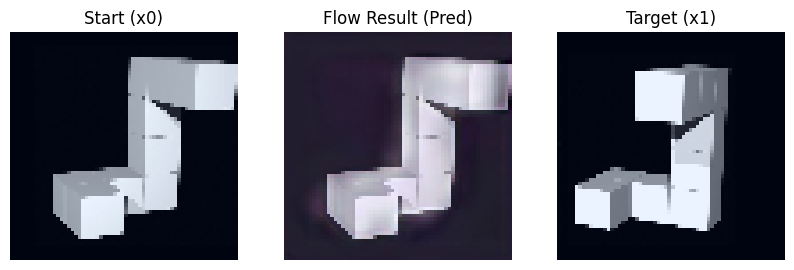

Epoch [15/20] Loss: 0.886207


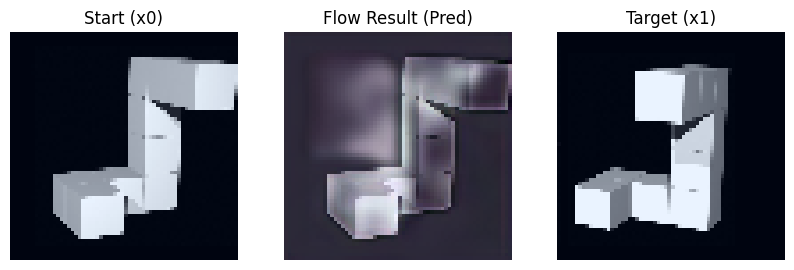

Epoch [20/20] Loss: 0.755627


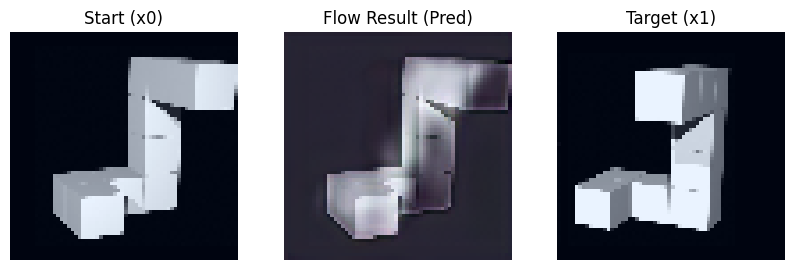

Training Complete.


In [ ]:
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.MSELoss()

EPOCHS = 20 

# This "simulates" the flow physics to generate an image from x0
@torch.no_grad()
def solve_flow_euler(model, x_start, steps=10):
    """
    Physically moves pixels from x_start to x_end using the learned velocity.
    Uses Euler integration (dt = 1/steps).
    """
    model.eval()
    dt = 1.0 / steps
    current_x = x_start.clone()
    
    # Time flows from 0.0 to 1.0
    for i in range(steps):
        t_value = i / steps
        # Create time tensor of shape (Batch, 1)
        t = torch.full((x_start.shape[0], 1), t_value, device=x_start.device)
        
        # Predict velocity at current state
        velocity = model(current_x, t, x_start)
        
        # Move state: x_new = x_old + velocity * dt
        current_x = current_x + velocity * dt
        
    return current_x

train_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for batch_idx, (x0, x1, _) in enumerate(train_loader):
        x0, x1 = x0.to(device), x1.to(device)
        batch_size = x0.shape[0]
        
        t = torch.rand(batch_size, 1, device=device)
        
        # x_t is the "noisy/mixed" state
        # Reshape t for broadcasting: (B, 1, 1, 1)
        t_view = t.view(batch_size, 1, 1, 1)
        x_t = (1 - t_view) * x0 + t_view * x1
        
        # The straight line direction from start to end
        target_velocity = x1 - x0
        
        # Predict velocity given state x_t, time t, and condition x0
        pred_velocity = model(x_t, t, x0)
        
        loss = criterion(pred_velocity, target_velocity)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.6f}")
        
        # Pick the first item from the test set to visualize progress
        sample_batch = next(iter(test_loader))
        # Filter for a 'same' pair for valid visualization
        same_indices = (sample_batch[2] == 1.0).nonzero(as_tuple=True)[0]
        if len(same_indices) > 0:
            idx = same_indices[0]
            vis_x0 = sample_batch[0][idx:idx+1].to(device)
            vis_x1 = sample_batch[1][idx:idx+1].to(device)
            
            # Run the Solver
            generated_x1 = solve_flow_euler(model, vis_x0, steps=20)
            
            fig, ax = plt.subplots(1, 3, figsize=(10, 3))
            
            # Helper to denormalize for display (approximate)
            def show_tens(ax, t, title):
                # Un-normalize (ImageNet stats) for display
                t = t.detach().cpu().squeeze().permute(1, 2, 0).numpy()
                t = (t - t.min()) / (t.max() - t.min())
                ax.imshow(t)
                ax.set_title(title)
                ax.axis('off')
                
            show_tens(ax[0], vis_x0, "Start (x0)")
            show_tens(ax[1], generated_x1, "Flow Result (Pred)")
            show_tens(ax[2], vis_x1, "Target (x1)")
            plt.show()

print("Training Complete.")